<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_projects/blob/main/DL_Projekt_StepanGarciu_135843.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wizja projektu



Na zajęciach z Głębokiego uczenia zapoznaliśmy się z klasyfikacją zbioru danych liczb i twarzy znanych osobistości. I jako projekt postanowiłem stworzyć kategoryzację ubrań. W tym celu zbiór danych Fashion MNIST posłuży jako doskonała podstawa do pracy.  Pomysłem na projekt był zbiór danych ze strony internetowej Kaggle: https://www.kaggle.com/zalando-research/fashionmnist  A praca niemieckiej firmy Zalando Research posłużyła jako inspiracja do wdrożenia klasyfikacji: https://github.com/zalandoresearch/fashion-mnist

# Klasyfikacja obrazu elementów odzieży

Teraz zbudujemy i wyszkolimy sieć neuronową, aby klasyfikować obrazy elementów odzieży, takich jak sukienki, buty, koszule itp.

## Instalowanie i importowanie zależności

In [ ]:
# Keras to biblioteka sieci neuronowych typu open source
import keras
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout 

# biblioteki wspierające
import numpy as np
import matplotlib.pyplot as plt

# Walidacja krzyżowa K-Fold
from sklearn.model_selection import KFold

##Importowanie zbioru danych Fashion MNIST

W tym przykładzie wykorzystano zbiór danych Fashion MNIST, który zawiera 70 000 zdjęć elementów odzieży w 10 kategoriach. Obrazy zawierają elementy garderoby w niskiej rozdzielczości (28x28 pikseli).

Użyjemy 60 000 obrazów do szkolenia sieci i 10 000 obrazów do przetestowania dokładności uczenia i klasyfikacji obrazów. 

In [ ]:
fashion = keras.datasets.fashion_mnist # Importowanie zbioru danych fashion_mnist do zmiennej FASHION
(train_images,train_labels),(test_images,test_labels) = fashion.load_data() # Podzielimy zbiór danych na treningowy i testowy

Ładując zestaw danych, uzyskujemy zestaw danych treningowych i zestaw danych testowych.



*   Model jest szkolony na zbiorze  danych z `train_images`
*   Model jest testowany na zbiorze danych z `test_images`

Obrazy to dwuwymiarowe tablice 28x28, w których wartości w każdej komórce mogą mieścić się w zakresie "[0, 255]". 

Każdy obraz należy do jednej etykiety - to tablica liczb całkowitych, gdzie każda wartość należy do zakresu „[0, 9]”. Zachowajmy nazwy klas do późniejszego wykorzystania podczas rysowania obrazów:

In [ ]:
class_names = ['Koszulka', "Spodnie", "Sweter", "Sukienka",
              "Kurtka", "Sandały", "Koszula", "Tenisówka", "Torba",
              "Buty"]

Stwórzmy funkcję, która pomoże nam narysować wykres:

In [ ]:
# Ładowanie treningowego i testowego zbioru danych
def load_dataset():
	# Ładowanie zbiorów danych
	(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
	# przekształcić zbiór danych, aby mieć jeden kanał
	train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
	test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))
	# kodowanie wartości docelowe
	train_labels = to_categorical(train_labels)
	test_labels = to_categorical(test_labels)
	return train_images, train_labels, test_images, test_labels

### Praca z danymi

Poniższy kod pokazuje, że 60 000 obrazów znajduje się w zestawie danych szkoleniowych, a 10 000 obrazów w zestawie testowym:

In [ ]:
print('Liczba egzemplarzy szkoleniowych: ', train_images.shape)
print('Liczba egzemplarzy testowych: ', test_images.shape)

Liczba egzemplarzy szkoleniowych:  (60000, 28, 28)
Liczba egzemplarzy testowych:  (10000, 28, 28)


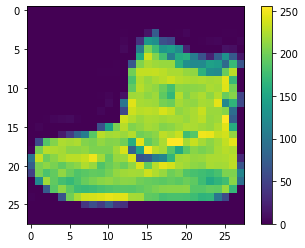

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

## Wstępne przetwarzanie danych

Wartość każdego piksela obrazu mieści się w zakresie [0,255]. Aby model działał poprawnie, wartości te muszą zostać znormalizowane - zredukowane do wartości z przedziału „[0,1]”. Dlatego poniżej deklarujemy i implementujemy funkcję normalizacyjną, a następnie stosujemy ją do każdego obrazu w zestawach danych uczących i testowych.

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
# skalowanie pikseli
def prep_pixels(train, test):
	# przekonwertowanie z liczb całkowitych na zmiennoprzecinkowe
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# znormalizowanie do zakresu 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# zwraca znormalizowane obrazy
	return train_norm, test_norm

### Badanie przetwarzanych danych

Narysujmy obrazek, aby mu się przyjrzeć:

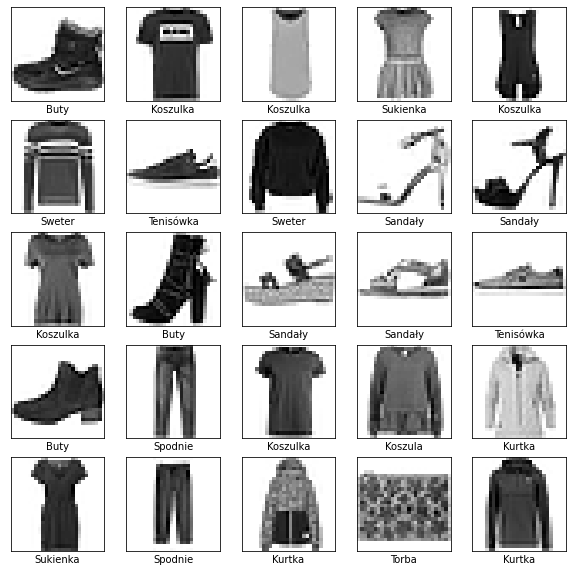

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Budowanie modelu

Budowa sieci neuronowej wymaga ustawienia warstw, a następnie złożenia modelu z funkcjami optymalizacji i strat.

###Konfigurowanie warstw

Podstawowym elementem budowy sieci neuronowej jest *warstwa*. Warstwa pobiera widok z danych, które otrzymuje jako dane wejściowe. W wyniku pracy kilku połączonych ze sobą warstw otrzymujemy pogląd, który ma sens dla rozwiązania problemu.

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Nasza sieć składa się z trzech warstw:

* **wejściowego** `keras.layers.Flatten` - ta warstwa konwertuje obrazy 28x28 na 1D tablicę 784 pikseli (28 * 28). Na tej warstwie nie mamy żadnych parametrów do uczenia, ponieważ ta warstwa zajmuje się tylko przekształcaniem danych wejściowych.

* **ukryta warstwa** `keras.layers.Dense` - ściśle połączona warstwa 128 neuronów. Każdy neuron (węzeł) przyjmuje jako dane wejściowe wszystkie 784 wartości z poprzedniej warstwy, zmienia wartości wejściowe zgodnie z wewnętrznymi wagami i odchyleniami podczas uczenia i zwraca pojedynczą wartość do następnej warstwy.

* **warstwa wyjściowa** `keras.layers.Dense` - `softmax`-warstwa składa się z 10 neuronów, z których każdy reprezentuje określoną klasę odzieży. Podobnie jak w poprzedniej warstwie, każdy neuron przyjmuje jako dane wejściowe wartości wszystkich 128 neuronów z poprzedniej warstwy. Wagi i odchylenia każdego neuronu w tej warstwie są zmieniane podczas treningu, tak że wynikowa wartość mieści się w przedziale „[0,1]” i przedstawia prawdopodobieństwo, że obraz należy do tej klasy. Suma wszystkich wartości wyjściowych 10 neuronów wynosi 1.

In [ ]:
# zdefiniujmy model
def define_model():
	model = Sequential()
	model.add(Flatten(input_shape=(28, 28)))
	model.add(Dense(128, activation='relu'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

###Skompilujmy model

Zanim zaczniemy trenować model, warto zrobić jeszcze kilka ustawień. Te ustawienia są wprowadzane w czasie kompilacji podczas wywoływania metody `compile`:

* ***optimizer*** - algorytm mierzący, jak bardzo pożądana wartość jest od przewidywanej.
* ***loss*** -algorytm „dopasowywania” parametrów wewnętrznych (wagi i odchylenia) modelu w celu zminimalizowania funkcji straty.
* ***metrics*** - służą do monitorowania procesu szkolenia i testowania. Poniższy przykład wykorzystuje takie wskaźniki, jak „precyzja”, czyli odsetek obrazów, które zostały poprawnie sklasyfikowane.

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Wytrenujmy model

Trenowanie odbywa się poprzez wywołanie metody `model.fit`:
1. Wysyła „train_images” jako dane wejściowe do modelu.
2. Model uczy się dopasowywać obraz wejściowy do etykiety.
3. Parametr „epochs = 20” ogranicza liczbę sesji treningowych do 10 pełnych iteracji szkoleniowych w zbiorze danych, co ostatecznie daje nam szkolenie dla 10 * 60 000 = 600 000 przykładów.

In [ ]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6089 - accuracy: 0.7884
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3865 - accuracy: 0.8598
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3378 - accuracy: 0.8744
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3118 - accuracy: 0.8849
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2901 - accuracy: 0.8917
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2748 - accuracy: 0.8978
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2635 - accuracy: 0.9029
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2525 - accuracy: 0.9058
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2399 - accuracy: 0.9109
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.235

Podczas uczenia modelu wartość funkcji straty i metryka dokładności są wyświetlane dla każdej iteracji uczenia. Ten model osiąga dokładność około 0,9 (90%) danych uczących.

### Sprawdzanie dokładności

Sprawdźmy dokładność modelu na danych testowych. Użyjmy wszystkich przykładów, które mamy w testowym zbiorze danych, aby sprawdzić dokładność.

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nDokładność na testowym zbiorze danych:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.3474 - accuracy: 0.8843

Dokładność na testowym zbiorze danych: 0.8842999935150146


Jak widać, dokładność testowego zestawu danych okazała się mniejsza niż dokładność zbioru uczącego. To jest w porządku, ponieważ model został przeszkolony na podstawie danych z zestawu danych „train_images”. Kiedy model znajdzie obrazy, których nigdy wcześniej nie widział (ze zbioru danych `train_images`), jest całkiem oczywiste, że wydajność klasyfikacji spadnie.

Możemy użyć wytrenowanego modelu do prognozowania niektórych obrazów.

In [ ]:
predictions = model.predict(test_images)

Możemy wyświetlić wszystkie obrazy wejściowe i odpowiadające im prognozy modelu w 10 klasach:

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

* Narysujemy pierwsze X obrazy testowe, ich przewidywane etykiety i prawdziwe etykiety.
* Pokolorujemy poprawne prognozy na niebiesko, a niepoprawne na czerwono.

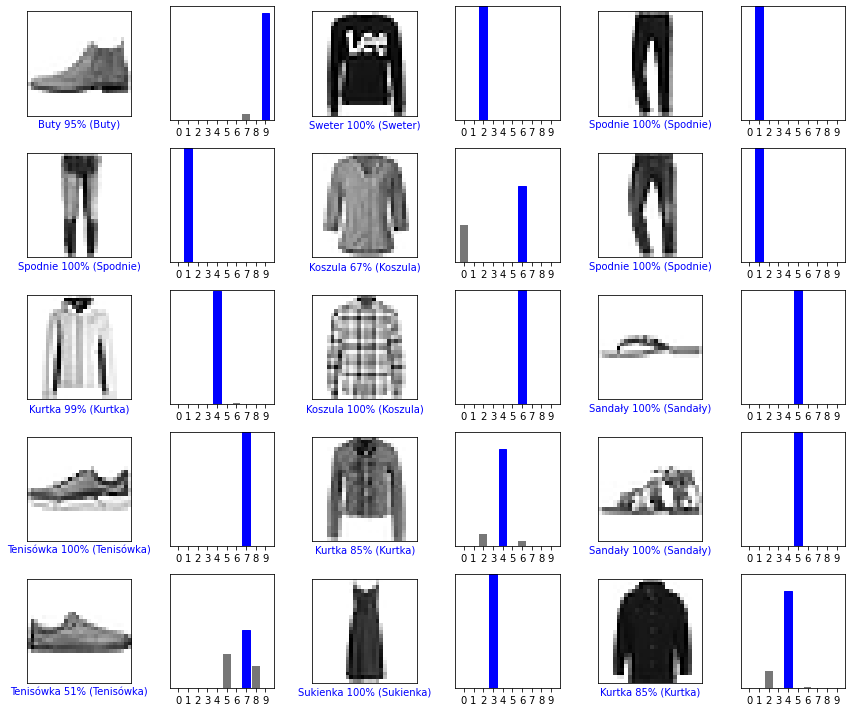

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [ ]:
history = model.fit(train_images, train_labels, epochs=100, batch_size=32, validation_data=(test_images, test_labels), verbose=0)

## Budowanie wykresu pomocniczego

In [ ]:
def plothist(hist):
    plt.figure(figsize=(8,5)) 
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('dokładność modelu')
    plt.ylabel('dokładność')
    plt.xlabel('epoka')
    plt.legend(['trening', 'test'], loc='upper left')
    plt.show()

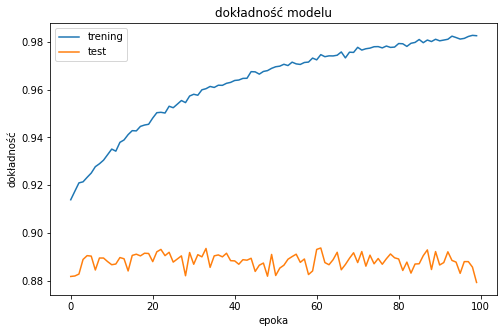

In [ ]:
plothist(history)

# Możemy ocenić model przy użyciu weryfikacji krzyżowej K-Folding

In [ ]:
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# przygotowanie walidacji krzyżowej
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# Wyliczanie podziały
	for train_ix, test_ix in kfold.split(dataX):
		# zdefiniujemy model
		model = define_model()
		# wybierzmy wiersze do treningu i testu
		train_images, train_labels, test_images, test_labels = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# dopasujemy model
		history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels), verbose=0)
		# Także możemy ocenić model
		_, acc = model.evaluate(test_images, test_labels, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# dołączamy wyniki
		scores.append(acc)
		histories.append(history)
	return scores, histories

Wykreślamy krzywe uczenia diagnostycznego:

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))  
  for i in range(len(histories)):	
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Strata')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    plt.ylim(0.25,0.6)
    plt.legend(['strata','wal_strata'])

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Dokładność klasyfikacji')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.ylim(0.8, 0.9)
    plt.legend(['dokładność','wal_dokładność'])
  plt.show()

Uruchamianie uprzęży testowej do oceny model:

In [ ]:
def run_test_harness():
	# Ładowanie zbioru danych
	train_images, train_labels, test_images, test_labels = load_dataset()
	# przygotowanie danych pikseli
	train_images, test_images = prep_pixels(train_images, test_images)
	# ocena modelu
	scores, histories = evaluate_model(train_images, train_labels)
	# krzywe uczenia się  
	summarize_diagnostics(histories)
	

# Wykres

> 87.925
> 88.475
> 88.458
> 87.792
> 88.375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


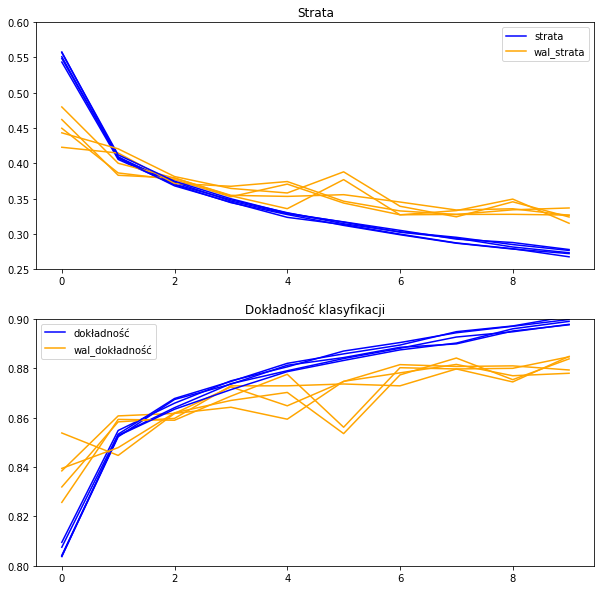

In [ ]:
run_test_harness()

## **Źródła inspiracji :**

* Wykłady z przedmiotu Głębokie uczenie
* https://www.kaggle.com/zalando-research/fashionmnist
* https://github.com/zalandoresearch/fashion-mnist
* Deep Learning with Keras + TensorFlow
<br>  https://www.youtube.com/watch?v=N3oMKS1AfVI 
* Use TensorFlow to classify clothing images
<br> https://www.youtube.com/watch?v=FiNglI1wRNk   
* How to use K-fold Cross Validation with TensorFlow and Keras?
<br> https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/ 
